## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

# Couldn't adjust as it is!!!

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'MS'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-51.94800,-19.89640,430.240,978474.78,978471.187227,3.592773
1,-51.92940,-19.95670,416.360,978478.44,978476.754617,1.685383
2,-54.83000,-18.77190,358.190,978465.31,978467.738477,-2.428477
3,-54.82210,-18.80660,345.940,978466.89,978463.346986,3.543014
4,-54.81780,-18.84640,325.280,978470.49,978466.482803,4.007197
...,...,...,...,...,...,...
3897,-51.27976,-19.50844,413.175,978442.46,978441.717015,0.742985
3898,-53.26800,-21.75460,387.824,978606.75,978605.359318,1.390682
3899,-52.82375,-21.30030,371.469,978572.19,978571.871272,0.318728
3900,-53.38146,-22.28474,355.780,978654.38,978653.374006,1.005994


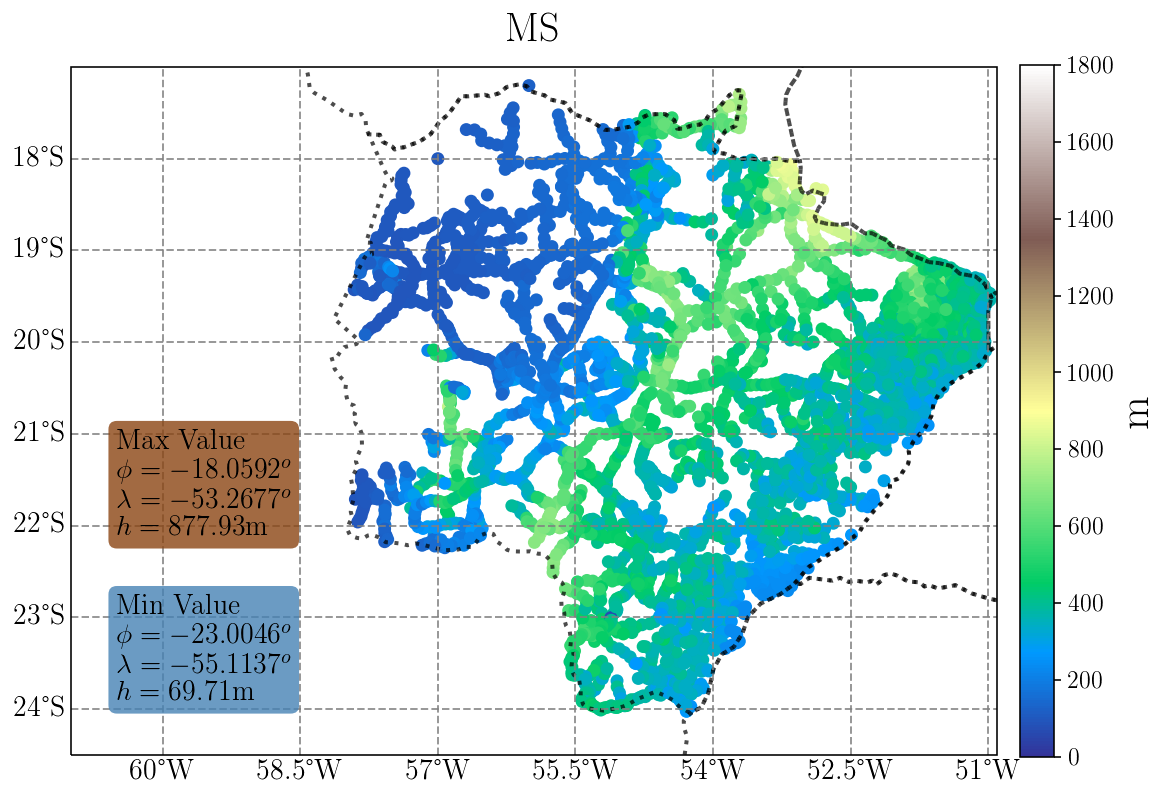

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(10.,12.), region=[-61,-50.9,-24.5,-17], \
          sign=(-60.5,-60.5,-22.1,-23.9), cmap='terrain', lim_val=(True,True,0.,1800.), shrink=0.53)

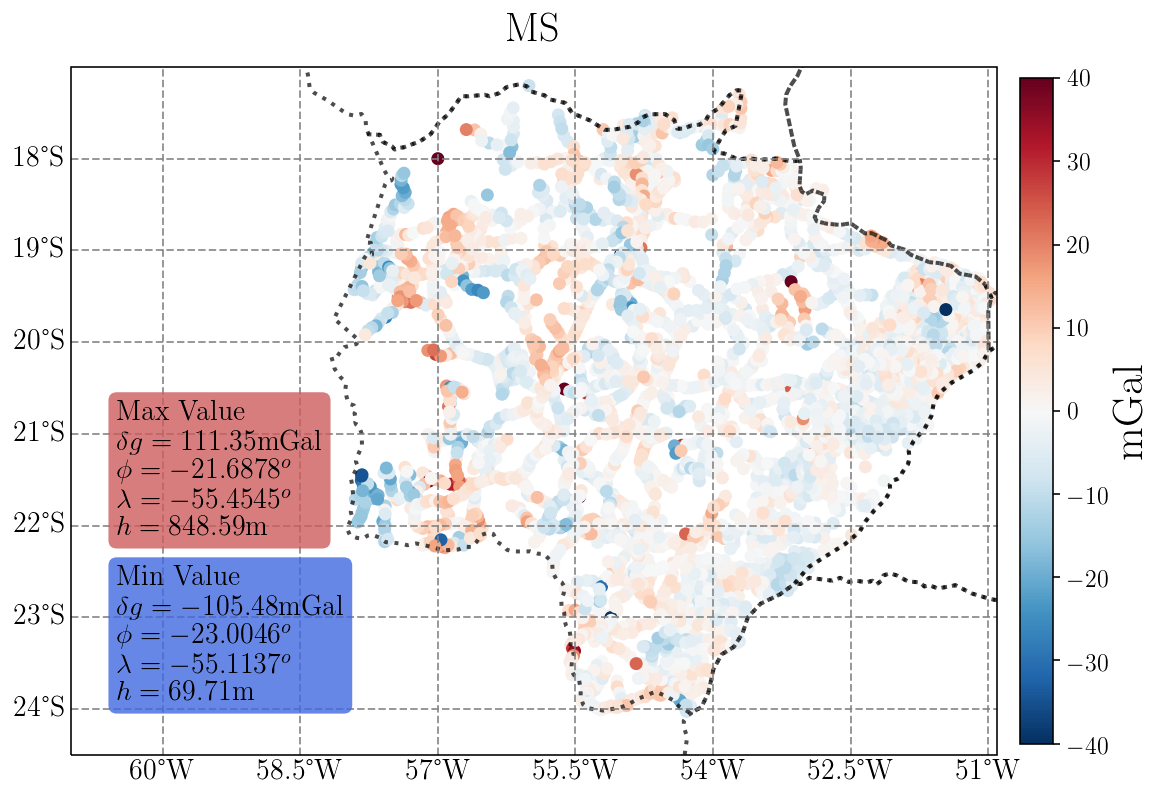

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(10.,12.), region=[-61,-50.9,-24.5,-17], \
          sign=(-60.5,-60.5,-22.1,-23.9), lim_val=(True, 40.), shrink=0.51)

In [8]:
# index = np.argmax(df.ALT.values)
# print('MAX', index, df.ALT[index], df.DIST[index])

# index = np.argmin(df.ALT.values)
# print('MIN', index, df.ALT[index], df.DIST[index])

In [9]:
index_max = np.argmax(df.DIST.values)
print('MAX', index_max, df.ALT[index_max], df.DIST[index_max])

index_min = np.argmin(df.DIST.values)
print('MIN', index_min, df.ALT[index_min], df.DIST[index_min])
print(disturb.size)

MAX 507 848.59 111.35328599996865
MIN 2844 69.71 -105.48477780004032
3902


In [10]:
disturb = np.delete(df.DIST.values, [index_min, index_max])
longitude = np.delete(df.LONG.values,[index_min, index_max])
latitude = np.delete(df.LAT.values, [index_min, index_max])
altitude = np.delete(df.ALT.values, [index_min, index_max])
print(disturb.size, longitude.size, latitude.size, altitude.size)

3900 3900 3900 3900


In [11]:
# index_max = np.argmax(disturb)
# print('MAX', index, altitude[index], disturb[index_max])

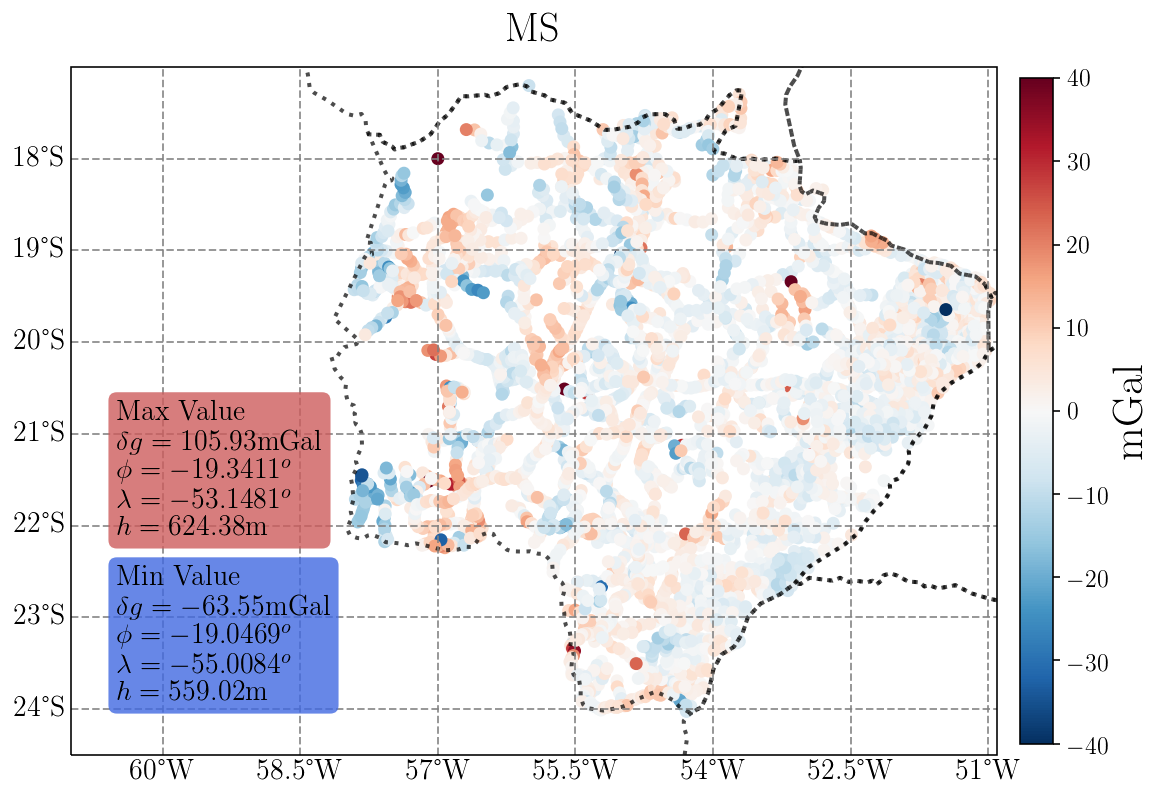

In [12]:
point_map(longitude, latitude, altitude, disturb, uf, fig_size=(10.,12.), region=[-61,-50.9,-24.5,-17], \
          sign=(-60.5,-60.5,-22.1,-23.9), lim_val=(True, 40.), shrink=0.51)

### Calculating rotation matrices and Cartesian coordinates

In [13]:
# Calculating Cartesian coordinates
# x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
# R = np.array(rotation_matrix(df.LONG, df.LAT))
x, y, z = geodetic2cartesian(longitude, latitude, altitude)
R = np.array(rotation_matrix(longitude, latitude))

## Estimating the first set of point-mass parameters

In [14]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [15]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-15
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [16]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

# latcl = df.LAT[indl]
# loncl = df.LONG[indl]
latcl = latitude[indl]
loncl = longitude[indl]

In [17]:
Rcl = R[:, indl]

In [18]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
# Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
Lay = EqLayer(longitude, latitude, np.zeros_like(longitude)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(3900, 3900)


In [19]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [20]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

3900


In [21]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [22]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

8.229717413662446

In [23]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [24]:
rabs_max.append(rabs_max_l)

In [25]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

8.229717413662446


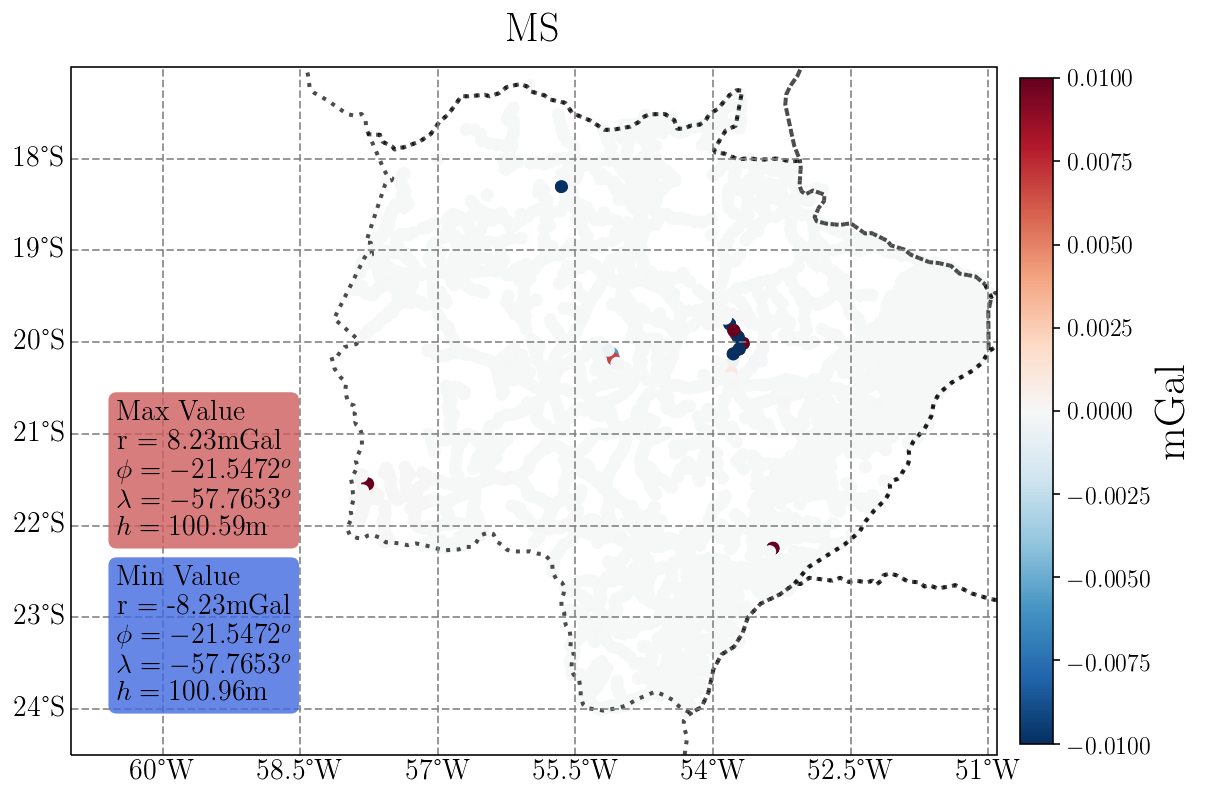

In [26]:
point_map(longitude, latitude, altitude, rc, uf, fig_size=(10.,12.), region=[-61,-50.9,-24.5,-17], \
          sign=(-60.5,-60.5,-22.1,-23.9), shrink=0.51, residual=True, lim_val=(True, 1e-2))

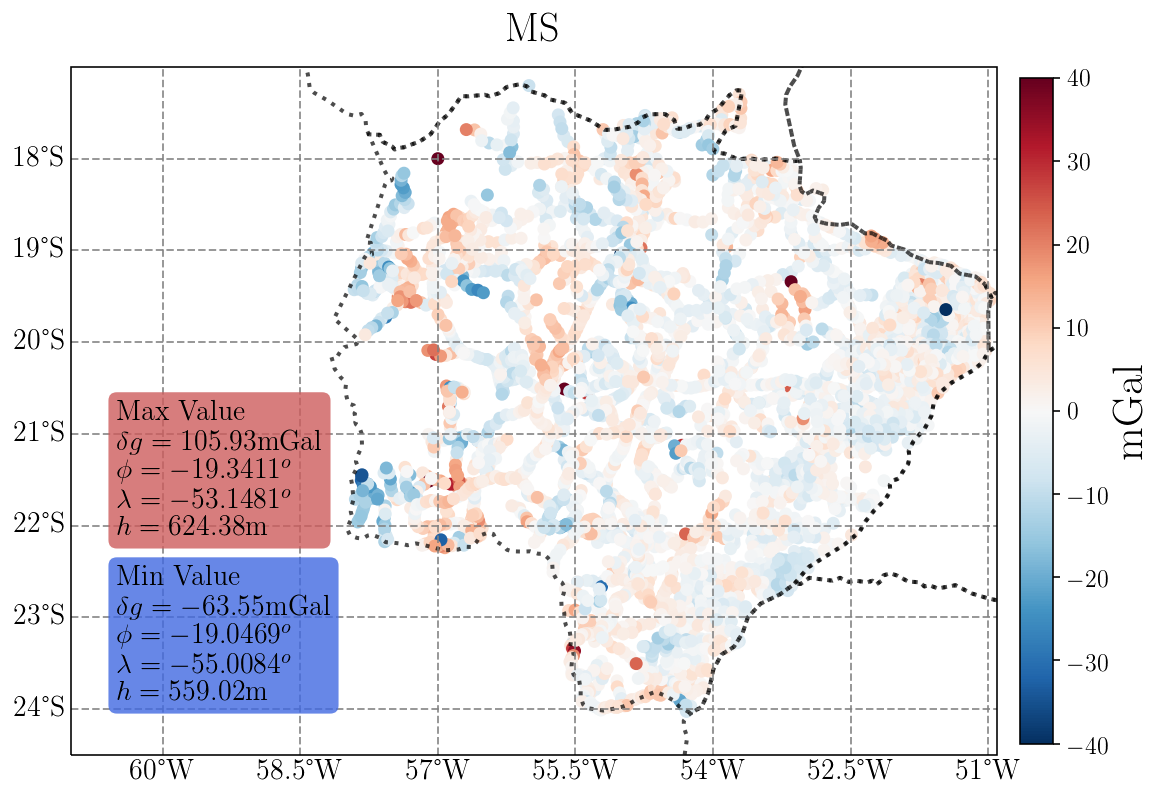

In [27]:
point_map(longitude, latitude, altitude, disturb, uf, fig_size=(10.,12.), region=[-61,-50.9,-24.5,-17], \
          sign=(-60.5,-60.5,-22.1,-23.9), lim_val=(True, 40.), shrink=0.51)

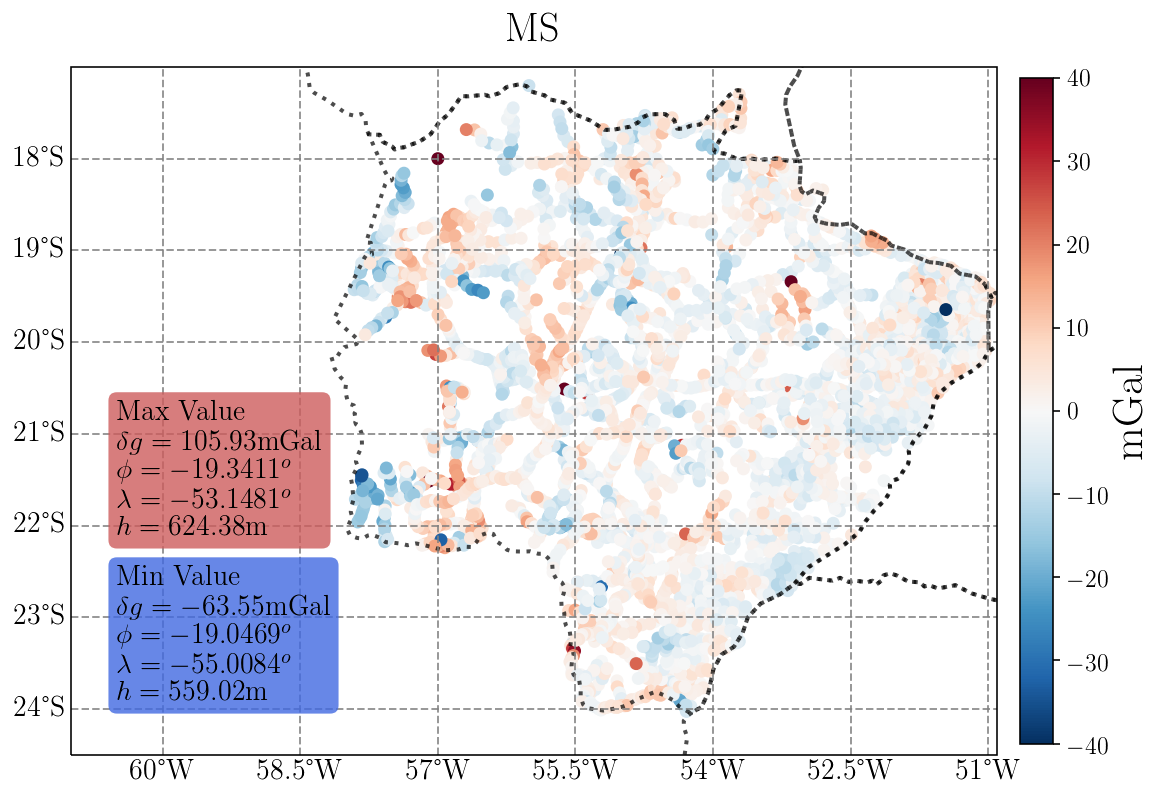

In [28]:
point_map(longitude, latitude, altitude, np.dot(Acc_l, p_L2), uf, fig_size=(10.,12.), \
          region=[-61,-50.9,-24.5,-17], sign=(-60.5,-60.5,-22.1,-23.9), lim_val=(True, 40.), shrink=0.51)

In [29]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [30]:
# new_data = {'LONG':df.LONG, \
#             'LAT':df.LAT, \
#             'ALT':df.ALT, \
#             'BDG':bdg.GRAV.values, \
#             'EIGEN':eigen.GRAV.values, \
#             'DIST':disturb, \
#             'RHO':p_L2, \
#             'RESID':rc}
new_data = {'LONG':longitude, \
            'LAT':latitude, \
            'ALT':altitude, \
            'BDG':np.delete(bdg.GRAV.values,[index_min, index_max]), \
            'EIGEN':np.delete(eigen.GRAV.values,[index_min, index_max]), \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-51.94800,-19.89640,430.240,978474.78,978471.187227,3.592773,1.479063e+12,-2.792734e-07
1,-51.92940,-19.95670,416.360,978478.44,978476.754617,1.685383,5.994111e+11,-2.572872e-07
2,-54.83000,-18.77190,358.190,978465.31,978467.738477,-2.428477,-1.805284e+12,-4.408092e-07
3,-54.82210,-18.80660,345.940,978466.89,978463.346986,3.543014,1.280022e+12,-4.023335e-07
4,-54.81780,-18.84640,325.280,978470.49,978466.482803,4.007197,5.979661e+11,-3.781540e-07
...,...,...,...,...,...,...,...,...
3895,-51.27976,-19.50844,413.175,978442.46,978441.717015,0.742985,2.257517e+12,-1.017419e-07
3896,-53.26800,-21.75460,387.824,978606.75,978605.359318,1.390682,5.998725e+11,-4.808739e-07
3897,-52.82375,-21.30030,371.469,978572.19,978571.871272,0.318728,9.709270e+11,-3.410314e-07
3898,-53.38146,-22.28474,355.780,978654.38,978653.374006,1.005994,-4.194123e+12,-2.529293e-05


In [31]:
print(df.RESID.min(), df.RESID.max())

-8.229717413662446 8.227630510603696


### Upward Continuation

In [32]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [33]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


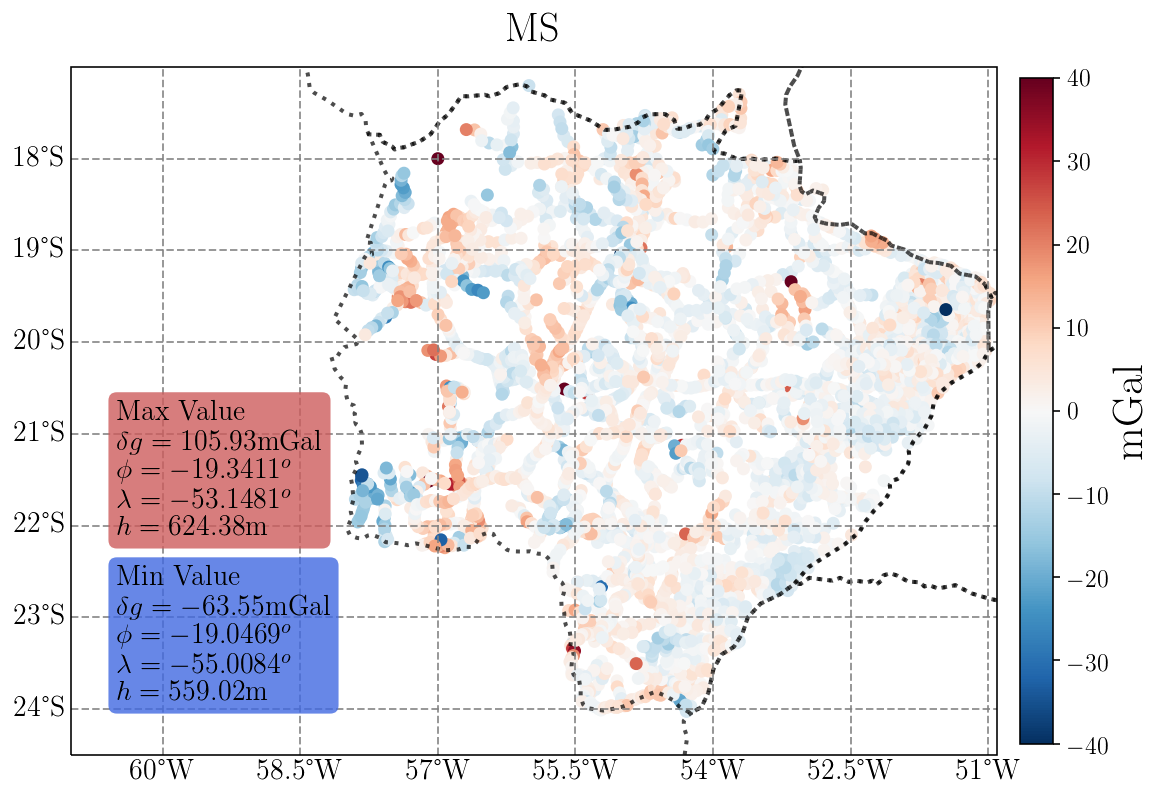

In [34]:
point_map(df.LONG, df.LAT, df.ALT, disturb, uf, fig_size=(10.,12.), region=[-61,-50.9,-24.5,-17], \
          sign=(-60.5,-60.5,-22.1,-23.9), lim_val=(True, 40.), shrink=0.51)

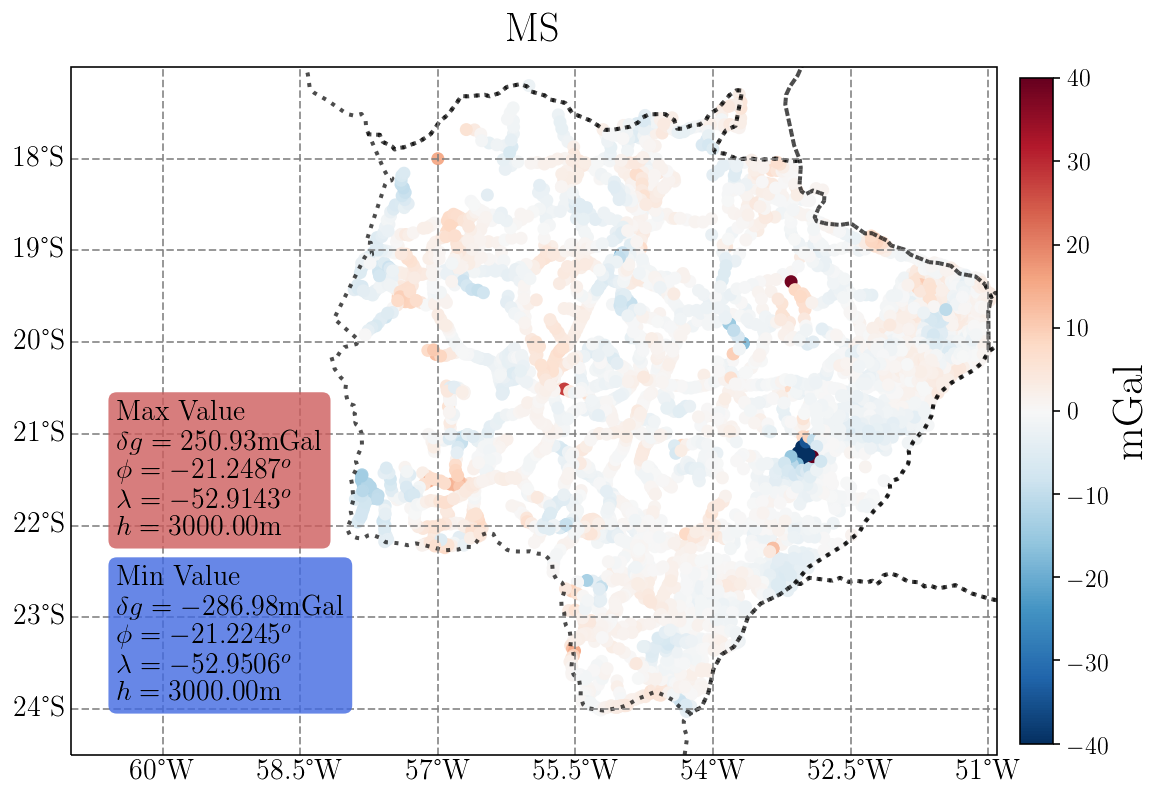

In [35]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(10.,12.), \
          region=[-61,-50.9,-24.5,-17], sign=(-60.5,-60.5,-22.1,-23.9), lim_val=(True, 40.), shrink=0.51)

In [36]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG, df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


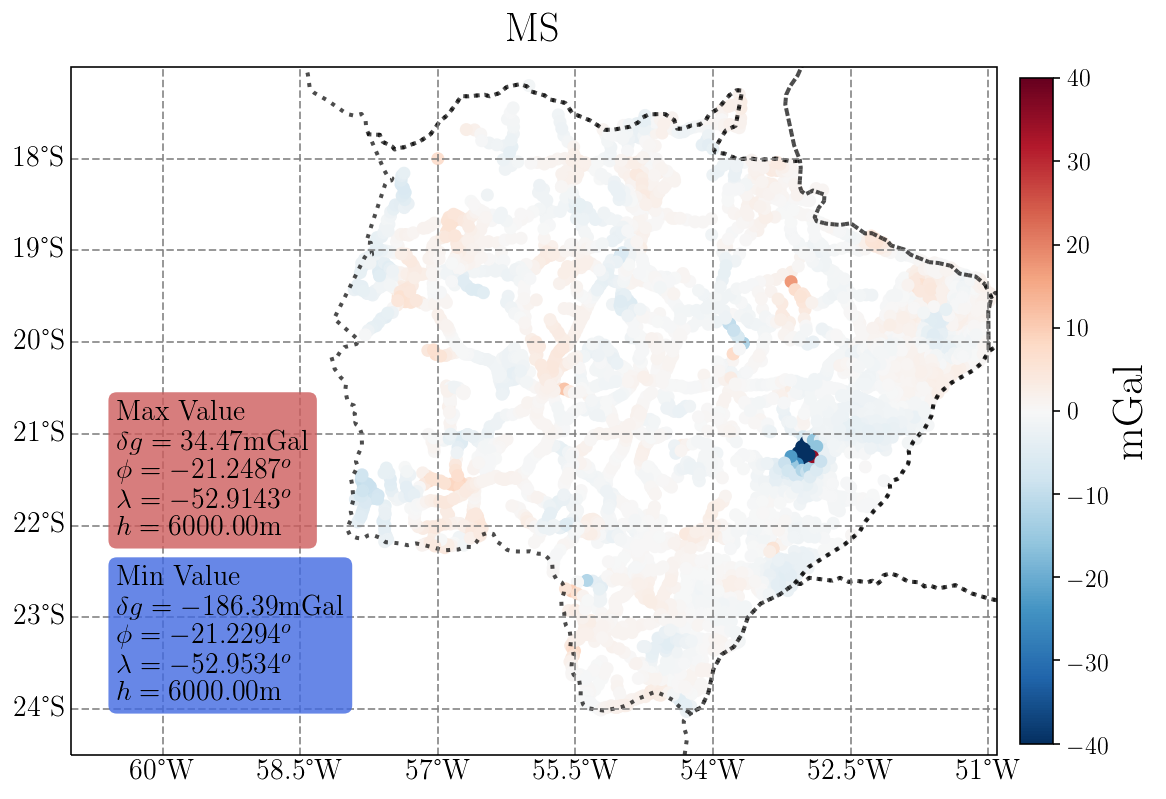

In [37]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(10.,12.), \
          region=[-61,-50.9,-24.5,-17], sign=(-60.5,-60.5,-22.1,-23.9), lim_val=(True, 40.), shrink=0.51)

In [38]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


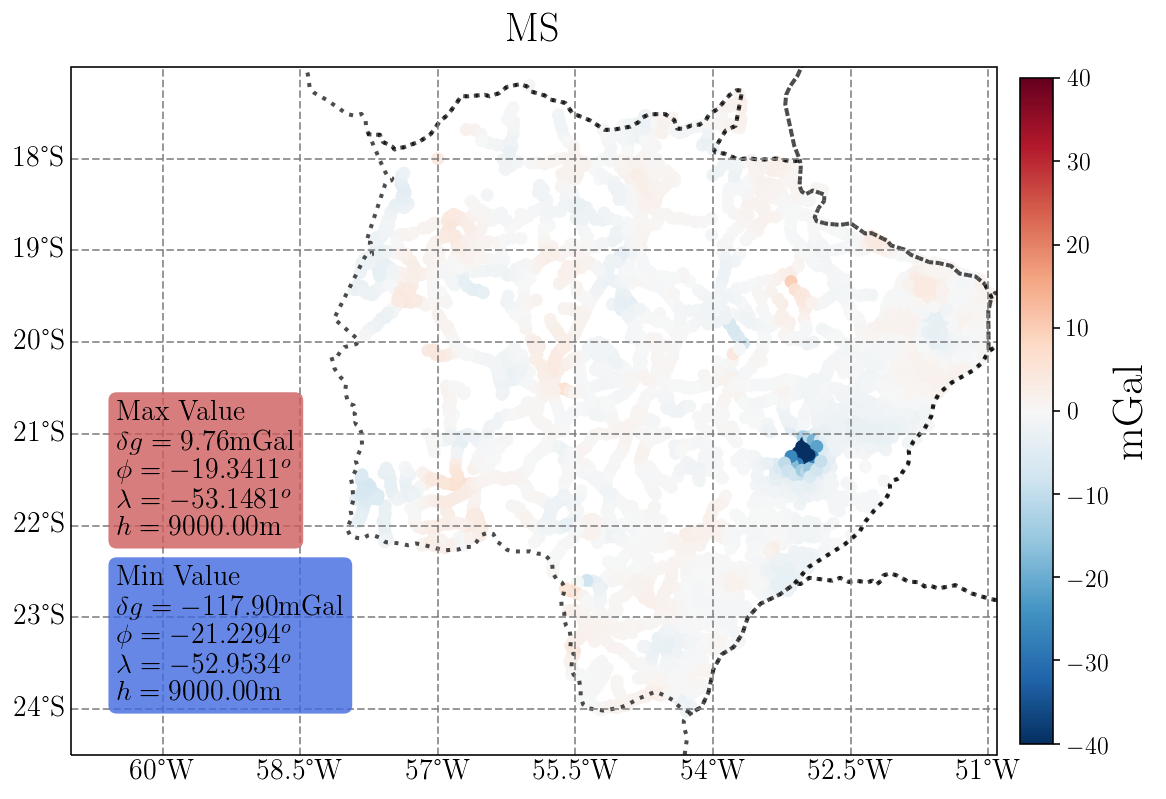

In [39]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(10.,12.), \
          region=[-61,-50.9,-24.5,-17], sign=(-60.5,-60.5,-22.1,-23.9), lim_val=(True, 40.), shrink=0.51)